In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import yfinance as yf
import pandas as pd
from scripts.utils import load_config
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.generate_secondary_stocks import calculate_indicators

In [2]:
# Let's set up our config settings so we have what we need.
config_path = os.path.join(project_root, 'config', 'config.yaml')
config = load_config(config_path)


In [3]:
# Now let's bring in the data we need from our config file.
core_tickers = config['yfinance']['core_tickers']
start_date = config['yfinance']['start_date']
end_date = config['yfinance']['end_date']

In [4]:



# Now let's start to bring in the data we need with the variables we just created.
def core_tickers_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start = start, end = end)[["Close", "Volume", "Open", "High", "Low"]].copy()
            
            stock_data = calculate_indicators(stock_data)
            
            stock_data.rename(columns = {
                'Close' : 'Close_core',
                'Open' : 'Open_core',
                'High' : 'High_core',
                'Low' : 'Low_core',
                'Volume' : 'Volume_core',
                'SMA_sec' : 'SMA_core',
                'EMA_sec' : 'EMA_core',
                'RSI_sec' : 'RSI_core',
                'BBM_sec' : 'BBM_core',
                'BBU_sec' : 'BBU_core',
                'BBL_sec' : 'BBL_core',
                'Stoch_K_sec' : 'Stoch_K_core',
                'Stoch_D_sec' : 'Stoch_D_core',
                'MACD_sec' : 'MACD_core',
                'MACD_Signal_sec' : 'MACD_Signal_core',
                'MACD_Hist_sec' : 'MACD_Hist_core',
                'ADX_14_sec' : 'ADX_14_core',
                'CCI_20_sec' : 'CCI_20_core',
                'ATR_14_sec' : 'ATR_14_core',
                'Momentum_1_sec' : 'Momentum_1_core',
                'Momentum_3_sec' : 'Momentum_3_core',
                'Momentum_7_sec' : 'Momentum_7_core',
                'Momentum_30_sec' : 'Momentum_30_core',
                'Momentum_50_sec' : 'Momentum_50_core',
                'OBV_sec' : 'OBV_core'
            }, inplace = True)
            
            data[ticker] = stock_data
        except Exception as e:
            print(f" Error downloading data for {ticker}: {e}")
    return data

def prep_time_series_df(data):
    df_list = []
    for ticker, df in data.items():
        df['Ticker'] = ticker
        df_list.append(df)
    combined_df = pd.concat(df_list)
    combined_df.reset_index(inplace=True)
    return combined_df

def check_missing_vals(df):
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    return missing_data

core_data = core_tickers_data(core_tickers, start_date, end_date)

df = prep_time_series_df(core_data)

# Set the start date to 03-14-2019 for our data pull so we have a fresh clean rolling window.
df = df[df['Date'] >= '2019-03-14']

df['Date'] = pd.to_datetime(df['Date'])


df_missing = check_missing_vals(df)
print("Missing values before filling methods:", df_missing)

# We have some missing values we need to address here.  Let's take a look.
df.head(15)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Missing values before filling methods: Momentum_50_core    10
dtype: int64


,Date,Close_core,Volume_core,Open_core,High_core,Low_core,SMA_core,EMA_core,RSI_core,BBM_core,...,ATR_14_core,Stoch_K_core,Stoch_D_core,Momentum_1_core,Momentum_3_core,Momentum_7_core,Momentum_30_core,Momentum_50_core,OBV_core,Ticker
49,2019-03-14,45.932499,94318000,45.974998,46.025002,45.639999,41.35925,42.219051,75.741602,41.35925,...,0.700179,97.465683,90.860103,0.504997,1.207500,2.049999,4.619999,NaN,1592190800,AAPL
50,2019-03-15,46.529999,156171600,46.212502,46.832500,45.935001,41.50025,42.388107,76.985910,41.50025,...,0.712679,93.213648,93.052540,0.597500,1.302498,2.899998,4.919998,7.049999,1748362400,AAPL
51,2019-03-18,47.005001,104879200,46.450001,47.097500,46.447498,41.72940,42.569162,78.724282,41.72940,...,0.721072,98.041317,96.240216,0.475002,1.577499,3.880001,5.375000,11.457500,1853241600,AAPL
52,2019-03-19,46.632500,126585600,47.087502,47.247501,46.480000,41.92075,42.728509,73.527018,41.92075,...,0.735358,87.378112,92.877692,-0.372501,0.700001,3.404999,3.820000,9.567501,1726656000,AAPL
53,2019-03-20,47.040001,124140800,46.557499,47.372501,46.182499,42.12190,42.897587,80.396901,42.12190,...,0.784822,93.346666,92.922032,0.407501,0.510002,2.315002,3.495003,10.057503,1850796800,AAPL
54,2019-03-21,48.772499,204136800,47.505001,49.082500,47.452499,42.34360,43.127975,83.758360,42.34360,...,0.890358,95.378288,92.034355,1.732498,1.767498,3.544998,5.212498,11.084999,2054933600,AAPL
55,2019-03-22,47.762501,169630800,48.834999,49.422501,47.695000,42.53230,43.309721,73.058243,42.53230,...,0.946251,76.445552,88.390169,-1.009998,1.130001,2.334999,5.027500,9.435001,1885302800,AAPL
56,2019-03-25,47.185001,175381200,47.877499,47.994999,46.650002,42.70700,43.461693,68.898438,42.70700,...,1.016250,68.251166,80.025002,-0.577499,0.145000,1.252502,4.582500,8.735001,1709921600,AAPL
57,2019-03-26,46.697498,199202000,47.915001,48.220001,46.145000,42.87950,43.588588,67.093876,42.87950,...,1.136072,61.333777,68.676832,-0.487503,-2.075001,0.167500,4.340000,8.625000,1510719600,AAPL
58,2019-03-27,47.117500,119393600,47.187500,47.439999,46.637501,43.07185,43.726976,72.461312,43.07185,...,1.148750,67.293365,65.626103,0.420002,-0.645000,0.112499,4.395000,9.617500,1630113200,AAPL


In [5]:
# Let's start to examine our missing values more closely.  Looks like we can easily impute the RSI data, that's not an issue.  The SMA on the other hand needs a closer look.
print(df_missing)

Momentum_50_core    10
dtype: int64


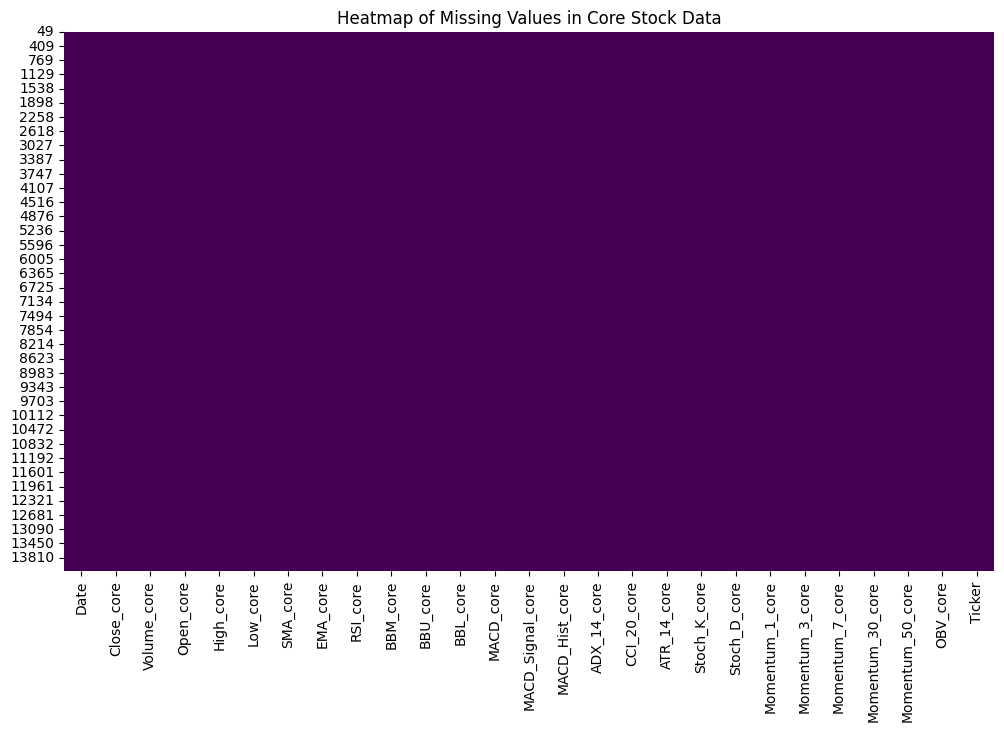

In [6]:
# Let's look at the location of those missing values and see if we can see if/how they are grouped.
plt.figure(figsize = (12,7))
sns.heatmap(df.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Core Stock Data')
plt.show()

#### Looking at the above you can't really tell where the missing values are, since we only have 10 missing values!.  These we will impute with surrounding values.  We will look to impute here with a combination of forward filling, back filling, and then linear interpolating as well to get the best idea of what those missing values are so we don't have to drop them entirely.

In [7]:
# Let's make a quick function for our imputation and interpolation, we may need this again.
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

df = df.copy()

for col in df.columns:
    if df[col].isnull().any():
        df.loc[:, col] = fill_missing_vals(df[[col]])[col]



print(df.isna().sum())


print(df.isna().sum())

Date                0
Close_core          0
Volume_core         0
Open_core           0
High_core           0
Low_core            0
SMA_core            0
EMA_core            0
RSI_core            0
BBM_core            0
BBU_core            0
BBL_core            0
MACD_core           0
MACD_Signal_core    0
MACD_Hist_core      0
ADX_14_core         0
CCI_20_core         0
ATR_14_core         0
Stoch_K_core        0
Stoch_D_core        0
Momentum_1_core     0
Momentum_3_core     0
Momentum_7_core     0
Momentum_30_core    0
Momentum_50_core    0
OBV_core            0
Ticker              0
dtype: int64
Date                0
Close_core          0
Volume_core         0
Open_core           0
High_core           0
Low_core            0
SMA_core            0
EMA_core            0
RSI_core            0
BBM_core            0
BBU_core            0
BBL_core            0
MACD_core           0
MACD_Signal_core    0
MACD_Hist_core      0
ADX_14_core         0
CCI_20_core         0
ATR_14_core        

C:\Users\ryanm\AppData\Local\Temp\ipykernel_3836\3017235574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_3836\3017235574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace = True)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_3836\3017235574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method = 'linear', inplace = True)


In [8]:
# So far so good.  Now let's start to set up and read in our exogenous data.
def dl_exogenous_data(start, end, exo_tickers):
    exo_data = {}
    for name, ticker in exo_tickers.items():
        try:
            data = yf.download(ticker, start = start, end = end)
            exo_data[name] = data['Close']
        except Exception as e:
            print(f"Error downloading data for {name} ({ticker}): {e}")
    exo_df = pd.DataFrame(exo_data)
    exo_df.reset_index(inplace=True)
    return exo_df

exo_tickers = config['yfinance']['exogenous_tickers']
exo_df = dl_exogenous_data(start_date, end_date, exo_tickers)

# Let's make sure our Date column is converted to datetime format to be used when we merge our dataframes for time series.
exo_df['Date'] = pd.to_datetime(exo_df['Date'])


# Let's take a quick look at the output.
print(exo_df.shape)
print(exo_df.describe())
exo_df.sample(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

(1467, 19)
                                Date  interest_rates_10yr         gold  \
count                           1467          1414.000000  1415.000000   
mean   2021-10-22 19:12:23.558282496             2.492530  1796.850315   
min              2019-01-01 00:00:00             0.499000  1269.300049   
25%              2020-05-27 12:00:00             1.487000  1677.949951   
50%              2021-10-22 00:00:00             2.209500  1813.699951   
75%              2023-03-20 12:00:00             3.746500  1933.850037   
max              2024-08-14 00:00:00             4.988000  2466.699951   
std                              NaN             1.280073   255.796580   

            copper     platinum       silver    crude_oil  natural_gas  \
count  1415.000000  1403.000000  1414.000000  1415.000000  1415.000000   
mean      3.601445   952.357661    22.000490    68.514057     3.370532   
min       2.119500   595.900024    11.735000   -37.630001     1.482000   
25%       2.887750   885.2

,Date,interest_rates_10yr,gold,copper,platinum,silver,crude_oil,natural_gas,corn,wheat,volatility_index,exchange_rate_usd_eur,exchange_rate_usd_jpy,sp500,nasdaq_100,dow_jones_industrial_average,consumer_confidence_index,vanguard_total_world_stock_etf,us_treasury_bond_etf
609,2021-05-03,1.607,1791.400024,4.5430,1227.900024,26.943001,64.489998,2.966,732.25,725.50,18.309999,1.202776,109.282997,4192.660156,13799.719727,34113.230469,187.699997,101.779999,26.350000
909,2022-06-27,3.194,1820.900024,3.7790,904.900024,21.159000,109.570000,6.501,744.25,904.00,26.950001,1.056613,135.061996,3900.110107,12008.240234,31438.259766,173.460007,87.489998,23.650000
359,2020-05-18,0.744,1731.800049,2.4050,864.700012,17.464001,31.820000,1.783,320.75,497.00,29.299999,1.082134,107.208000,2953.909912,9331.929688,24597.369141,156.399994,70.589996,27.900000
1269,2023-11-13,4.632,1945.500000,3.6625,857.000000,22.299000,78.260002,3.197,477.25,579.00,14.760000,1.069016,151.468994,4411.549805,15482.790039,34337.871094,95.540001,94.709999,22.020000
178,2019-09-06,1.550,1506.199951,2.6155,956.900024,17.968000,56.520000,2.496,342.50,460.25,15.000000,1.103631,107.071999,2978.709961,7852.540039,26797.460938,146.440002,75.059998,26.500000
767,2021-12-09,1.487,1774.599976,4.3300,937.299988,21.974001,70.940002,3.814,588.50,773.50,21.580000,1.134559,113.683998,4667.450195,16149.570312,35754.691406,189.619995,106.540001,26.480000
75,2019-04-16,2.592,1272.599976,2.9305,880.200012,14.891000,64.050003,2.572,359.00,445.00,12.180000,1.130493,111.943001,2907.060059,7654.729980,26452.660156,124.610001,75.260002,24.930000
1115,2023-04-11,3.434,2004.800049,4.0245,995.599976,25.131001,81.529999,2.186,651.00,674.00,19.100000,1.086933,133.468994,4108.939941,12964.150391,33684.789062,134.509995,92.309998,23.430000
128,2019-06-28,2.000,1409.699951,2.7055,835.500000,15.253000,58.470001,2.308,420.25,528.00,15.080000,1.137294,107.747002,2941.760010,7671.080078,26599.960938,130.350006,75.160004,25.820000
1278,2023-11-24,4.472,2002.199951,3.7965,931.099976,24.329000,75.540001,2.855,463.25,548.75,12.460000,1.090631,149.634995,4559.339844,15982.009766,35390.148438,103.580002,98.330002,22.219999


In [9]:
# Just looking at the sample readout we can see we have at least one row of missing values, time to investigate!
exo_df_missing = check_missing_vals(exo_df)
print(exo_df_missing)


interest_rates_10yr               53
gold                              52
copper                            52
platinum                          64
silver                            53
crude_oil                         52
natural_gas                       52
corn                              53
wheat                             53
volatility_index                  53
exchange_rate_usd_eur              1
exchange_rate_usd_jpy              1
sp500                             53
nasdaq_100                        53
dow_jones_industrial_average      53
consumer_confidence_index         53
vanguard_total_world_stock_etf    53
us_treasury_bond_etf              53
dtype: int64


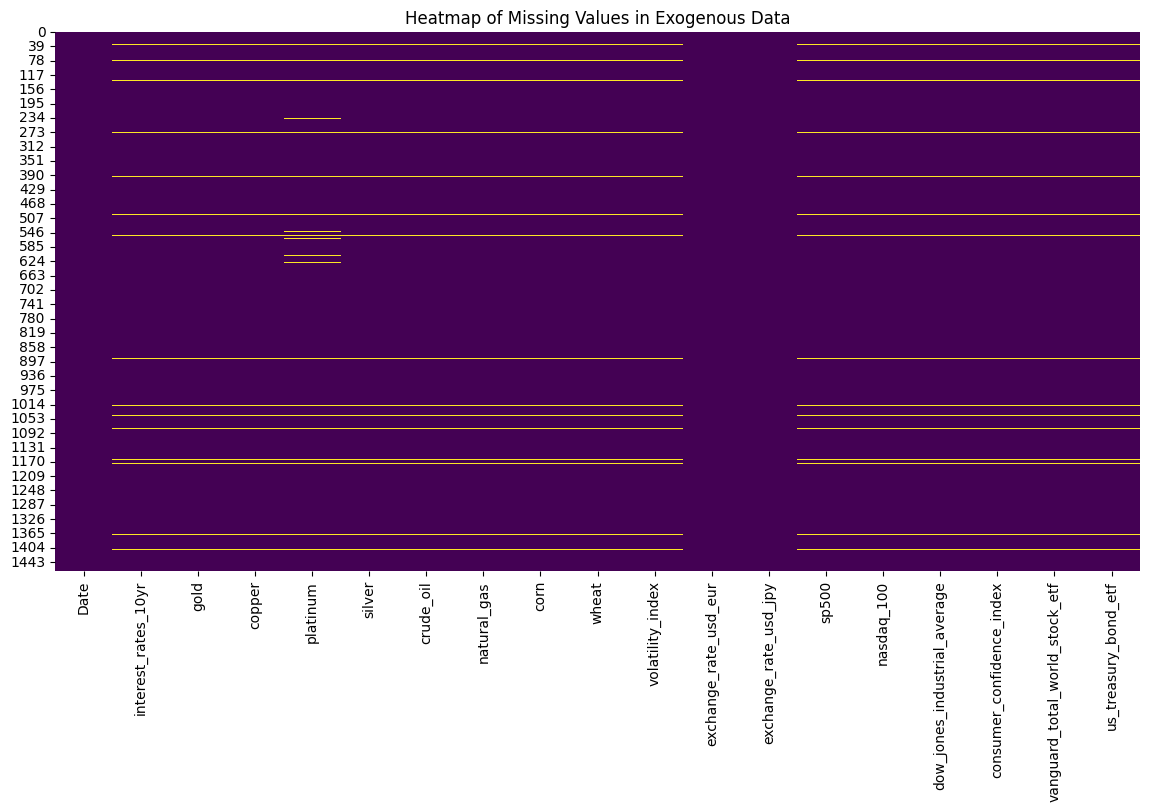

In [10]:
# Looks like mostly 52 rows, upwards of 63 for platinum. Before we address filling the missing values let's look a little closer at the missing values themselves with a heatmap and a correlation matrix.
plt.figure(figsize = (14,7))
sns.heatmap(exo_df.isna(), cbar = False, cmap = 'viridis')
plt.title('Heatmap of Missing Values in Exogenous Data')
plt.show()

#### Above you can see that our missing values are held constant across all rows and features, save for the platinum column that has a few more missing columns.  This will make it easier for us to impute our values.

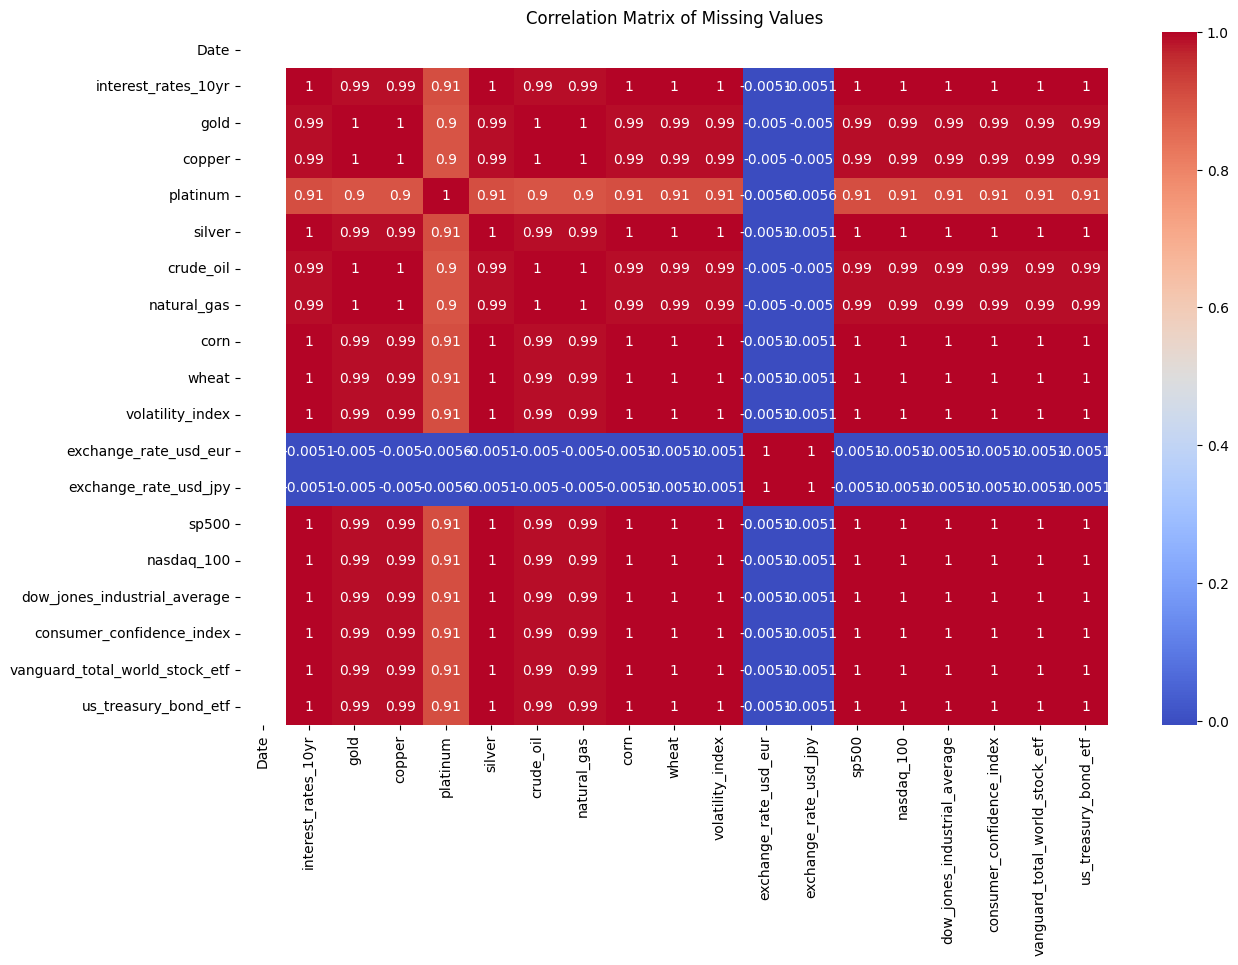

In [11]:
# Now let's plot the correlation matrix to see the relationship between missing values and their corresponding features.
na_df = exo_df.isna().astype(int)
plt.figure(figsize = (14,9))
sns.heatmap(na_df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix of Missing Values')
plt.show()

#### What we can take from the above plot is that the commodities (gold, silver, copper, etc.) are all highly correlated, meaning when one of those features has a missing value there is a high likelihood (over 90%) that another commodity will also be missing data for that date.  We can also see that the exchange rate data is showing very low correlation relationship, pretty much negative in fact for all relationships (aside from each other).  

In [12]:
# Now that we have properly identified and reviewed the missing values, let's go ahead and fill them, then check again to make sure all values are accounted for.
exo_df = fill_missing_vals(exo_df)

print(exo_df.isna().sum())

Date                              0
interest_rates_10yr               0
gold                              0
copper                            0
platinum                          0
silver                            0
crude_oil                         0
natural_gas                       0
corn                              0
wheat                             0
volatility_index                  0
exchange_rate_usd_eur             0
exchange_rate_usd_jpy             0
sp500                             0
nasdaq_100                        0
dow_jones_industrial_average      0
consumer_confidence_index         0
vanguard_total_world_stock_etf    0
us_treasury_bond_etf              0
dtype: int64


In [13]:
# Before saving I want to take both of these dataframes and make sure Date is our index for our EDA phase.
df.reset_index(drop = True, inplace = True)
df.set_index('Date', inplace = True)

exo_df.reset_index(drop = True, inplace = True)
exo_df.set_index('Date', inplace = True)

print(df.head())
print(exo_df.head())

            Close_core  Volume_core  Open_core  High_core   Low_core  \
Date                                                                   
2019-03-14   45.932499     94318000  45.974998  46.025002  45.639999   
2019-03-15   46.529999    156171600  46.212502  46.832500  45.935001   
2019-03-18   47.005001    104879200  46.450001  47.097500  46.447498   
2019-03-19   46.632500    126585600  47.087502  47.247501  46.480000   
2019-03-20   47.040001    124140800  46.557499  47.372501  46.182499   

            SMA_core   EMA_core   RSI_core  BBM_core   BBU_core  ...  \
Date                                                             ...   
2019-03-14  41.35925  42.219051  75.741602  41.35925  46.695085  ...   
2019-03-15  41.50025  42.388107  76.985910  41.50025  47.003365  ...   
2019-03-18  41.72940  42.569162  78.724282  41.72940  47.174667  ...   
2019-03-19  41.92075  42.728509  73.527018  41.92075  47.369412  ...   
2019-03-20  42.12190  42.897587  80.396901  42.12190  47.569044

In [14]:
# Great, let's save this data to another csv file for quick reference if we should need it.
df.to_csv(os.path.join(project_root, 'data', 'core_stock_data.csv'), index = True)

exo_df.to_csv(os.path.join(project_root, 'data', 'exogenous_data.csv'), index = True)